In [1]:
import numpy as np
import os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2025-08-01 14:05:42.756858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-01 14:05:42.756909: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/awong/racecar-neo-installer/tpu-venv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/awong/racecar-neo-installer/tpu-venv/lib/python3.9/site-pa

In [2]:
# Using Custom Dataset ### CHANGE ME IF NEEDED ###
print(os.getcwd())
dataset_path = "/home/awong/racecar-neo-installer/tpu-venv/ml-stuff/elevator"
images_path = dataset_path + "/images"
labels_path = dataset_path + "/Annotations"

# Label Map
label_map = {1: 'stop', 2:'go'}

# label_map = {1:"Car"}

print(f"Images: {images_path}")
print(f"Labels: {labels_path}")

/home/awong/racecar-neo-installer/tpu-venv/ml-stuff
Images: /home/awong/racecar-neo-installer/tpu-venv/ml-stuff/elevator/images
Labels: /home/awong/racecar-neo-installer/tpu-venv/ml-stuff/elevator/Annotations


In [3]:
import os
import random
import shutil

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpeg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpeg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [4]:
def clean_xml_declaration(annotations_dir):
    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            path = os.path.join(annotations_dir, filename)
            with open(path, 'rb') as f:
                content = f.read()
            # Remove XML declaration if present
            if content.startswith(b'<?xml'):
                first_line_end = content.find(b'?>') + 2
                content = content[first_line_end:].lstrip()
            with open(path, 'wb') as f:
                f.write(content)

In [5]:
# Split data into train, validation, test
train_dir, val_dir, test_dir = split_dataset(images_path, labels_path, val_split=0.2, test_split=0.2, out_path='elevator-split-dataset')

# Clean data coming in from Label Studio
clean_xml_declaration(os.path.join(train_dir, 'annotations'))
clean_xml_declaration(os.path.join(val_dir, 'annotations'))
clean_xml_declaration(os.path.join(test_dir, 'annotations'))

train_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'annotations'), label_map=label_map)

validation_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'annotations'), label_map=label_map)

test_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(test_dir, 'images'),
    os.path.join(test_dir, 'annotations'), label_map=label_map)

In [6]:
# Select a model
spec = object_detector.EfficientDetLite0Spec()

2025-08-01 14:05:46.811253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/awong/racecar-neo-installer/tpu-venv/lib/python3.9/site-packages/cv2/../../lib64:
2025-08-01 14:05:46.811520: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-01 14:05:46.811562: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-LDSLUOHM): /proc/driver/nvidia/version does not exist
2025-08-01 14:05:46.814126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Train the model
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=50, 
                               batch_size=10, 
                               train_whole_model=True)

Epoch 1/50


2025-08-01 14:05:52.700718: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - ETA: 0s - det_loss: 1.7276 - cls_loss: 1.1336 - box_loss: 0.0119 - reg_l2_loss: 0.0630 - loss: 1.7906 - learning_rate: 0.0101 - gradient_norm: 1.6437

2025-08-01 14:06:25.330983: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 36s 2s/step - det_loss: 1.7294 - cls_loss: 1.1311 - box_loss: 0.0120 - reg_l2_loss: 0.0630 - loss: 1.7923 - learning_rate: 0.0102 - gradient_norm: 1.6567 - val_det_loss: 1.5221 - val_cls_loss: 1.0446 - val_box_loss: 0.0096 - val_reg_l2_loss: 0.0630 - val_loss: 1.5851
Epoch 2/50
13/13 [==============================] - 17s 1s/step - det_loss: 1.3793 - cls_loss: 0.9079 - box_loss: 0.0094 - reg_l2_loss: 0.0630 - loss: 1.4422 - learning_rate: 0.0125 - gradient_norm: 2.3973 - val_det_loss: 1.8117 - val_cls_loss: 1.4092 - val_box_loss: 0.0080 - val_reg_l2_loss: 0.0630 - val_loss: 1.8746
Epoch 3/50
13/13 [==============================] - ETA: 0s - det_loss: 0.9868 - cls_loss: 0.6050 - box_loss: 0.0076 - reg_l2_loss: 0.0630 - loss: 1.0498 - learning_rate: 0.0124 - gradient_norm: 2.5267

2025-08-01 14:07:01.433812: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 17s 1s/step - det_loss: 0.9683 - cls_loss: 0.5931 - box_loss: 0.0075 - reg_l2_loss: 0.0630 - loss: 1.0313 - learning_rate: 0.0124 - gradient_norm: 2.4843 - val_det_loss: 0.8037 - val_cls_loss: 0.4864 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0630 - val_loss: 0.8668
Epoch 4/50
13/13 [==============================] - 17s 1s/step - det_loss: 0.8048 - cls_loss: 0.4626 - box_loss: 0.0068 - reg_l2_loss: 0.0630 - loss: 0.8678 - learning_rate: 0.0123 - gradient_norm: 2.7027 - val_det_loss: 0.7370 - val_cls_loss: 0.3541 - val_box_loss: 0.0077 - val_reg_l2_loss: 0.0630 - val_loss: 0.8001
Epoch 5/50
13/13 [==============================] - ETA: 0s - det_loss: 0.7331 - cls_loss: 0.3777 - box_loss: 0.0071 - reg_l2_loss: 0.0630 - loss: 0.7961 - learning_rate: 0.0122 - gradient_norm: 2.9150

2025-08-01 14:07:35.825953: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 21s 2s/step - det_loss: 0.7173 - cls_loss: 0.3699 - box_loss: 0.0069 - reg_l2_loss: 0.0630 - loss: 0.7804 - learning_rate: 0.0122 - gradient_norm: 2.8960 - val_det_loss: 0.7272 - val_cls_loss: 0.3411 - val_box_loss: 0.0077 - val_reg_l2_loss: 0.0631 - val_loss: 0.7903
Epoch 6/50
13/13 [==============================] - 17s 1s/step - det_loss: 0.6688 - cls_loss: 0.3627 - box_loss: 0.0061 - reg_l2_loss: 0.0631 - loss: 0.7319 - learning_rate: 0.0121 - gradient_norm: 2.2229 - val_det_loss: 0.5967 - val_cls_loss: 0.3306 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0631 - val_loss: 0.6598
Epoch 7/50
13/13 [==============================] - ETA: 0s - det_loss: 0.6311 - cls_loss: 0.3251 - box_loss: 0.0061 - reg_l2_loss: 0.0631 - loss: 0.6941 - learning_rate: 0.0120 - gradient_norm: 2.3217

2025-08-01 14:08:14.850747: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 18s 1s/step - det_loss: 0.6250 - cls_loss: 0.3212 - box_loss: 0.0061 - reg_l2_loss: 0.0631 - loss: 0.6880 - learning_rate: 0.0120 - gradient_norm: 2.3316 - val_det_loss: 0.5706 - val_cls_loss: 0.2758 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0631 - val_loss: 0.6337
Epoch 8/50
13/13 [==============================] - 17s 1s/step - det_loss: 0.5429 - cls_loss: 0.2789 - box_loss: 0.0053 - reg_l2_loss: 0.0631 - loss: 0.6060 - learning_rate: 0.0118 - gradient_norm: 2.5726 - val_det_loss: 0.5529 - val_cls_loss: 0.2796 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0631 - val_loss: 0.6160
Epoch 9/50
13/13 [==============================] - ETA: 0s - det_loss: 0.5268 - cls_loss: 0.2736 - box_loss: 0.0051 - reg_l2_loss: 0.0631 - loss: 0.5899 - learning_rate: 0.0116 - gradient_norm: 2.4032

2025-08-01 14:08:48.911360: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 17s 1s/step - det_loss: 0.5219 - cls_loss: 0.2695 - box_loss: 0.0050 - reg_l2_loss: 0.0631 - loss: 0.5850 - learning_rate: 0.0116 - gradient_norm: 2.3950 - val_det_loss: 0.4484 - val_cls_loss: 0.2288 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0631 - val_loss: 0.5115
Epoch 10/50
13/13 [==============================] - 19s 1s/step - det_loss: 0.4766 - cls_loss: 0.2519 - box_loss: 0.0045 - reg_l2_loss: 0.0631 - loss: 0.5397 - learning_rate: 0.0114 - gradient_norm: 2.2599 - val_det_loss: 0.4507 - val_cls_loss: 0.2306 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0631 - val_loss: 0.5138
Epoch 11/50
13/13 [==============================] - ETA: 0s - det_loss: 0.4461 - cls_loss: 0.2345 - box_loss: 0.0042 - reg_l2_loss: 0.0631 - loss: 0.5093 - learning_rate: 0.0111 - gradient_norm: 2.4079

2025-08-01 14:09:26.256881: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 19s 1s/step - det_loss: 0.4367 - cls_loss: 0.2315 - box_loss: 0.0041 - reg_l2_loss: 0.0631 - loss: 0.4999 - learning_rate: 0.0111 - gradient_norm: 2.4026 - val_det_loss: 0.4474 - val_cls_loss: 0.2287 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0631 - val_loss: 0.5105
Epoch 12/50
13/13 [==============================] - 18s 1s/step - det_loss: 0.4191 - cls_loss: 0.2335 - box_loss: 0.0037 - reg_l2_loss: 0.0631 - loss: 0.4822 - learning_rate: 0.0109 - gradient_norm: 2.7286 - val_det_loss: 0.5104 - val_cls_loss: 0.2906 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0631 - val_loss: 0.5736
Epoch 13/50
13/13 [==============================] - ETA: 0s - det_loss: 0.4457 - cls_loss: 0.2386 - box_loss: 0.0041 - reg_l2_loss: 0.0632 - loss: 0.5089 - learning_rate: 0.0106 - gradient_norm: 2.6234

2025-08-01 14:10:00.938615: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 16s 1s/step - det_loss: 0.4477 - cls_loss: 0.2380 - box_loss: 0.0042 - reg_l2_loss: 0.0632 - loss: 0.5109 - learning_rate: 0.0106 - gradient_norm: 2.6801 - val_det_loss: 0.4155 - val_cls_loss: 0.2189 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0632 - val_loss: 0.4786
Epoch 14/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.4633 - cls_loss: 0.2315 - box_loss: 0.0046 - reg_l2_loss: 0.0632 - loss: 0.5265 - learning_rate: 0.0103 - gradient_norm: 2.7368 - val_det_loss: 0.4675 - val_cls_loss: 0.2447 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0632 - val_loss: 0.5306
Epoch 15/50
13/13 [==============================] - ETA: 0s - det_loss: 0.4358 - cls_loss: 0.2207 - box_loss: 0.0043 - reg_l2_loss: 0.0632 - loss: 0.4990 - learning_rate: 0.0100 - gradient_norm: 2.1907

2025-08-01 14:10:33.072297: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 18s 1s/step - det_loss: 0.4377 - cls_loss: 0.2209 - box_loss: 0.0043 - reg_l2_loss: 0.0632 - loss: 0.5009 - learning_rate: 0.0100 - gradient_norm: 2.1989 - val_det_loss: 0.4055 - val_cls_loss: 0.2019 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0632 - val_loss: 0.4687
Epoch 16/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.4058 - cls_loss: 0.2098 - box_loss: 0.0039 - reg_l2_loss: 0.0632 - loss: 0.4689 - learning_rate: 0.0097 - gradient_norm: 2.4684 - val_det_loss: 0.4130 - val_cls_loss: 0.1996 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0632 - val_loss: 0.4762
Epoch 17/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3863 - cls_loss: 0.2124 - box_loss: 0.0035 - reg_l2_loss: 0.0632 - loss: 0.4495 - learning_rate: 0.0093 - gradient_norm: 2.2527

2025-08-01 14:11:06.456360: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 16s 1s/step - det_loss: 0.3833 - cls_loss: 0.2118 - box_loss: 0.0034 - reg_l2_loss: 0.0632 - loss: 0.4465 - learning_rate: 0.0093 - gradient_norm: 2.2263 - val_det_loss: 0.3787 - val_cls_loss: 0.1980 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0632 - val_loss: 0.4419
Epoch 18/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.3355 - cls_loss: 0.1833 - box_loss: 0.0030 - reg_l2_loss: 0.0632 - loss: 0.3987 - learning_rate: 0.0090 - gradient_norm: 2.0581 - val_det_loss: 0.3732 - val_cls_loss: 0.2037 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0632 - val_loss: 0.4364
Epoch 19/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3807 - cls_loss: 0.2091 - box_loss: 0.0034 - reg_l2_loss: 0.0632 - loss: 0.4439 - learning_rate: 0.0086 - gradient_norm: 2.2798

2025-08-01 14:11:36.814314: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.3780 - cls_loss: 0.2063 - box_loss: 0.0034 - reg_l2_loss: 0.0632 - loss: 0.4412 - learning_rate: 0.0086 - gradient_norm: 2.2557 - val_det_loss: 0.4289 - val_cls_loss: 0.2286 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.0632 - val_loss: 0.4921
Epoch 20/50
13/13 [==============================] - 17s 1s/step - det_loss: 0.3345 - cls_loss: 0.1928 - box_loss: 0.0028 - reg_l2_loss: 0.0632 - loss: 0.3977 - learning_rate: 0.0082 - gradient_norm: 2.3536 - val_det_loss: 0.3826 - val_cls_loss: 0.1937 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0632 - val_loss: 0.4458
Epoch 21/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3574 - cls_loss: 0.1968 - box_loss: 0.0032 - reg_l2_loss: 0.0632 - loss: 0.4206 - learning_rate: 0.0078 - gradient_norm: 2.3201

2025-08-01 14:12:08.878552: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.3528 - cls_loss: 0.1947 - box_loss: 0.0032 - reg_l2_loss: 0.0632 - loss: 0.4160 - learning_rate: 0.0078 - gradient_norm: 2.3548 - val_det_loss: 0.4031 - val_cls_loss: 0.2284 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0632 - val_loss: 0.4663
Epoch 22/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.3247 - cls_loss: 0.1845 - box_loss: 0.0028 - reg_l2_loss: 0.0632 - loss: 0.3879 - learning_rate: 0.0074 - gradient_norm: 2.3052 - val_det_loss: 0.3543 - val_cls_loss: 0.1891 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0632 - val_loss: 0.4175
Epoch 23/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3414 - cls_loss: 0.1950 - box_loss: 0.0029 - reg_l2_loss: 0.0632 - loss: 0.4046 - learning_rate: 0.0071 - gradient_norm: 2.4719

2025-08-01 14:12:39.970448: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 16s 1s/step - det_loss: 0.3429 - cls_loss: 0.1986 - box_loss: 0.0029 - reg_l2_loss: 0.0632 - loss: 0.4061 - learning_rate: 0.0071 - gradient_norm: 2.5098 - val_det_loss: 0.3572 - val_cls_loss: 0.1903 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0632 - val_loss: 0.4205
Epoch 24/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.3629 - cls_loss: 0.1868 - box_loss: 0.0035 - reg_l2_loss: 0.0632 - loss: 0.4261 - learning_rate: 0.0067 - gradient_norm: 2.5131 - val_det_loss: 0.3398 - val_cls_loss: 0.1887 - val_box_loss: 0.0030 - val_reg_l2_loss: 0.0632 - val_loss: 0.4031
Epoch 25/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3475 - cls_loss: 0.1847 - box_loss: 0.0033 - reg_l2_loss: 0.0632 - loss: 0.4108 - learning_rate: 0.0063 - gradient_norm: 2.0290

2025-08-01 14:13:11.895090: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 17s 1s/step - det_loss: 0.3417 - cls_loss: 0.1838 - box_loss: 0.0032 - reg_l2_loss: 0.0632 - loss: 0.4049 - learning_rate: 0.0063 - gradient_norm: 2.0344 - val_det_loss: 0.3552 - val_cls_loss: 0.1923 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0632 - val_loss: 0.4184
Epoch 26/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.2996 - cls_loss: 0.1661 - box_loss: 0.0027 - reg_l2_loss: 0.0632 - loss: 0.3629 - learning_rate: 0.0059 - gradient_norm: 2.3862 - val_det_loss: 0.3247 - val_cls_loss: 0.1796 - val_box_loss: 0.0029 - val_reg_l2_loss: 0.0632 - val_loss: 0.3879
Epoch 27/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3173 - cls_loss: 0.1762 - box_loss: 0.0028 - reg_l2_loss: 0.0632 - loss: 0.3806 - learning_rate: 0.0055 - gradient_norm: 2.2458

2025-08-01 14:13:43.858297: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.3271 - cls_loss: 0.1793 - box_loss: 0.0030 - reg_l2_loss: 0.0632 - loss: 0.3904 - learning_rate: 0.0055 - gradient_norm: 2.2841 - val_det_loss: 0.3608 - val_cls_loss: 0.1949 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0632 - val_loss: 0.4240
Epoch 28/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.2708 - cls_loss: 0.1603 - box_loss: 0.0022 - reg_l2_loss: 0.0632 - loss: 0.3340 - learning_rate: 0.0051 - gradient_norm: 2.1988 - val_det_loss: 0.3499 - val_cls_loss: 0.1945 - val_box_loss: 0.0031 - val_reg_l2_loss: 0.0632 - val_loss: 0.4131
Epoch 29/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3003 - cls_loss: 0.1693 - box_loss: 0.0026 - reg_l2_loss: 0.0632 - loss: 0.3635 - learning_rate: 0.0047 - gradient_norm: 2.2954

2025-08-01 14:14:14.729330: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.2980 - cls_loss: 0.1681 - box_loss: 0.0026 - reg_l2_loss: 0.0632 - loss: 0.3612 - learning_rate: 0.0047 - gradient_norm: 2.2601 - val_det_loss: 0.3249 - val_cls_loss: 0.1924 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.0632 - val_loss: 0.3882
Epoch 30/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.3005 - cls_loss: 0.1649 - box_loss: 0.0027 - reg_l2_loss: 0.0632 - loss: 0.3637 - learning_rate: 0.0043 - gradient_norm: 2.3357 - val_det_loss: 0.3556 - val_cls_loss: 0.1869 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0632 - val_loss: 0.4188
Epoch 31/50
13/13 [==============================] - ETA: 0s - det_loss: 0.3019 - cls_loss: 0.1747 - box_loss: 0.0025 - reg_l2_loss: 0.0632 - loss: 0.3651 - learning_rate: 0.0039 - gradient_norm: 2.4225

2025-08-01 14:14:45.751989: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.3003 - cls_loss: 0.1727 - box_loss: 0.0026 - reg_l2_loss: 0.0632 - loss: 0.3635 - learning_rate: 0.0039 - gradient_norm: 2.3862 - val_det_loss: 0.3563 - val_cls_loss: 0.1976 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0632 - val_loss: 0.4195
Epoch 32/50
13/13 [==============================] - 14s 1s/step - det_loss: 0.3380 - cls_loss: 0.1880 - box_loss: 0.0030 - reg_l2_loss: 0.0632 - loss: 0.4013 - learning_rate: 0.0035 - gradient_norm: 2.5011 - val_det_loss: 0.3092 - val_cls_loss: 0.1761 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.0632 - val_loss: 0.3724
Epoch 33/50
13/13 [==============================] - ETA: 0s - det_loss: 0.2802 - cls_loss: 0.1670 - box_loss: 0.0023 - reg_l2_loss: 0.0632 - loss: 0.3434 - learning_rate: 0.0032 - gradient_norm: 2.7290

2025-08-01 14:15:16.326286: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 16s 1s/step - det_loss: 0.2773 - cls_loss: 0.1637 - box_loss: 0.0023 - reg_l2_loss: 0.0632 - loss: 0.3405 - learning_rate: 0.0032 - gradient_norm: 2.6605 - val_det_loss: 0.3203 - val_cls_loss: 0.1706 - val_box_loss: 0.0030 - val_reg_l2_loss: 0.0632 - val_loss: 0.3836
Epoch 34/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.2751 - cls_loss: 0.1605 - box_loss: 0.0023 - reg_l2_loss: 0.0632 - loss: 0.3383 - learning_rate: 0.0028 - gradient_norm: 2.2807 - val_det_loss: 0.3096 - val_cls_loss: 0.1696 - val_box_loss: 0.0028 - val_reg_l2_loss: 0.0632 - val_loss: 0.3728
Epoch 35/50
13/13 [==============================] - ETA: 0s - det_loss: 0.2656 - cls_loss: 0.1562 - box_loss: 0.0022 - reg_l2_loss: 0.0632 - loss: 0.3288 - learning_rate: 0.0025 - gradient_norm: 2.3301

2025-08-01 14:15:47.385170: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 17s 1s/step - det_loss: 0.2684 - cls_loss: 0.1589 - box_loss: 0.0022 - reg_l2_loss: 0.0632 - loss: 0.3317 - learning_rate: 0.0025 - gradient_norm: 2.4311 - val_det_loss: 0.2841 - val_cls_loss: 0.1549 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0632 - val_loss: 0.3473
Epoch 36/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.2618 - cls_loss: 0.1587 - box_loss: 0.0021 - reg_l2_loss: 0.0632 - loss: 0.3251 - learning_rate: 0.0022 - gradient_norm: 2.4080 - val_det_loss: 0.2802 - val_cls_loss: 0.1647 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0632 - val_loss: 0.3434
Epoch 37/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.3571 - cls_loss: 0.1814 - box_loss: 0.0035 - reg_l2_loss: 0.0632 - loss: 0.4203 - learning_rate: 0.0019 - gradient_norm: 3.3490 - val_det_loss: 0.3171 - val_cls_loss: 0.1793 - val_box_loss: 0.0028 - val_reg_l2_loss: 0.0632 - val_loss: 0.3803
Epoch 38/50
13/13 [==============================

2025-08-01 14:16:31.627460: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 14s 1s/step - det_loss: 0.2288 - cls_loss: 0.1402 - box_loss: 0.0018 - reg_l2_loss: 0.0632 - loss: 0.2920 - learning_rate: 0.0016 - gradient_norm: 2.2443 - val_det_loss: 0.3205 - val_cls_loss: 0.1706 - val_box_loss: 0.0030 - val_reg_l2_loss: 0.0632 - val_loss: 0.3837
Epoch 39/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.2685 - cls_loss: 0.1533 - box_loss: 0.0023 - reg_l2_loss: 0.0632 - loss: 0.3318 - learning_rate: 0.0014 - gradient_norm: 2.1711 - val_det_loss: 0.2938 - val_cls_loss: 0.1626 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0632 - val_loss: 0.3571
Epoch 40/50
13/13 [==============================] - ETA: 0s - det_loss: 0.2423 - cls_loss: 0.1443 - box_loss: 0.0020 - reg_l2_loss: 0.0632 - loss: 0.3055 - learning_rate: 0.0011 - gradient_norm: 2.0238

2025-08-01 14:17:02.685895: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 17s 1s/step - det_loss: 0.2413 - cls_loss: 0.1446 - box_loss: 0.0019 - reg_l2_loss: 0.0632 - loss: 0.3046 - learning_rate: 0.0011 - gradient_norm: 2.0392 - val_det_loss: 0.3083 - val_cls_loss: 0.1715 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.0632 - val_loss: 0.3715
Epoch 41/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.2429 - cls_loss: 0.1491 - box_loss: 0.0019 - reg_l2_loss: 0.0632 - loss: 0.3062 - learning_rate: 9.0750e-04 - gradient_norm: 2.1129 - val_det_loss: 0.2912 - val_cls_loss: 0.1659 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0632 - val_loss: 0.3545
Epoch 42/50
13/13 [==============================] - ETA: 0s - det_loss: 0.2276 - cls_loss: 0.1406 - box_loss: 0.0017 - reg_l2_loss: 0.0632 - loss: 0.2908 - learning_rate: 7.1684e-04 - gradient_norm: 2.0565

2025-08-01 14:17:33.014953: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 14s 1s/step - det_loss: 0.2305 - cls_loss: 0.1403 - box_loss: 0.0018 - reg_l2_loss: 0.0632 - loss: 0.2938 - learning_rate: 7.1081e-04 - gradient_norm: 2.0387 - val_det_loss: 0.2883 - val_cls_loss: 0.1682 - val_box_loss: 0.0024 - val_reg_l2_loss: 0.0632 - val_loss: 0.3515
Epoch 43/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.3147 - cls_loss: 0.1743 - box_loss: 0.0028 - reg_l2_loss: 0.0632 - loss: 0.3779 - learning_rate: 5.3688e-04 - gradient_norm: 2.5703 - val_det_loss: 0.3005 - val_cls_loss: 0.1739 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0632 - val_loss: 0.3637
Epoch 44/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.2308 - cls_loss: 0.1470 - box_loss: 0.0017 - reg_l2_loss: 0.0632 - loss: 0.2940 - learning_rate: 3.8643e-04 - gradient_norm: 2.2053 - val_det_loss: 0.3087 - val_cls_loss: 0.1748 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.0632 - val_loss: 0.3720
Epoch 45/50
13/13 [==================

2025-08-01 14:18:17.873385: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 16s 1s/step - det_loss: 0.2527 - cls_loss: 0.1504 - box_loss: 0.0020 - reg_l2_loss: 0.0632 - loss: 0.3159 - learning_rate: 2.6007e-04 - gradient_norm: 2.2948 - val_det_loss: 0.3034 - val_cls_loss: 0.1724 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0632 - val_loss: 0.3666
Epoch 46/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.2477 - cls_loss: 0.1493 - box_loss: 0.0020 - reg_l2_loss: 0.0632 - loss: 0.3110 - learning_rate: 1.5833e-04 - gradient_norm: 2.0790 - val_det_loss: 0.2987 - val_cls_loss: 0.1708 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0632 - val_loss: 0.3619
Epoch 47/50
13/13 [==============================] - ETA: 0s - det_loss: 0.2420 - cls_loss: 0.1488 - box_loss: 0.0019 - reg_l2_loss: 0.0632 - loss: 0.3053 - learning_rate: 8.3642e-05 - gradient_norm: 2.2799

2025-08-01 14:18:48.573736: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.2380 - cls_loss: 0.1472 - box_loss: 0.0018 - reg_l2_loss: 0.0632 - loss: 0.3013 - learning_rate: 8.1620e-05 - gradient_norm: 2.2579 - val_det_loss: 0.2951 - val_cls_loss: 0.1698 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0632 - val_loss: 0.3584
Epoch 48/50
13/13 [==============================] - 15s 1s/step - det_loss: 0.2391 - cls_loss: 0.1483 - box_loss: 0.0018 - reg_l2_loss: 0.0632 - loss: 0.3023 - learning_rate: 3.0256e-05 - gradient_norm: 2.1252 - val_det_loss: 0.2945 - val_cls_loss: 0.1701 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0632 - val_loss: 0.3577
Epoch 49/50
13/13 [==============================] - ETA: 0s - det_loss: 0.2307 - cls_loss: 0.1424 - box_loss: 0.0018 - reg_l2_loss: 0.0632 - loss: 0.2939 - learning_rate: 4.7875e-06 - gradient_norm: 2.0056

2025-08-01 14:19:18.855826: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


13/13 [==============================] - 15s 1s/step - det_loss: 0.2283 - cls_loss: 0.1418 - box_loss: 0.0017 - reg_l2_loss: 0.0632 - loss: 0.2916 - learning_rate: 4.4510e-06 - gradient_norm: 2.0190 - val_det_loss: 0.2947 - val_cls_loss: 0.1705 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0632 - val_loss: 0.3580
Epoch 50/50
13/13 [==============================] - 16s 1s/step - det_loss: 0.2323 - cls_loss: 0.1395 - box_loss: 0.0019 - reg_l2_loss: 0.0632 - loss: 0.2956 - learning_rate: 4.3100e-06 - gradient_norm: 2.0460 - val_det_loss: 0.2947 - val_cls_loss: 0.1707 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0632 - val_loss: 0.3580


In [8]:
metrics = model.evaluate(test_data)

1/1 [==============================] - 6s 6s/step



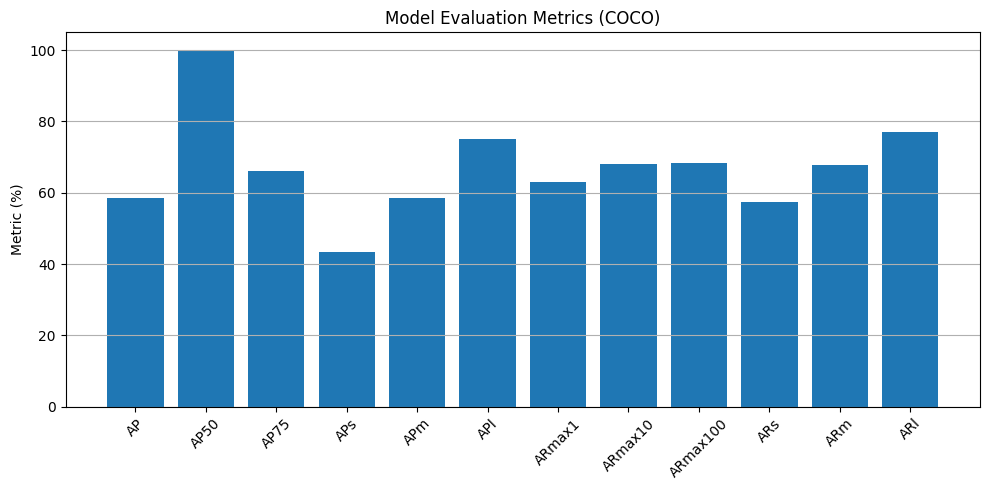

In [9]:
import matplotlib.pyplot as plt

# Clean label names
labels = [k for k in metrics if not k.startswith('AP_/')]
values = [metrics[k] * 100 for k in labels]  # Convert to %

plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.ylabel('Metric (%)')
plt.title('Model Evaluation Metrics (COCO)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [10]:
TFLITE_FILENAME = 'elevator.tflite' # Rename output here!
LABELS_FILENAME = 'elevator-objects.txt'

model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

2025-08-01 14:19:44.091236: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2025-08-01 14:19:56.779732: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2025-08-01 14:20:00.526743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2025-08-01 14:20:00.526853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2025-08-01 14:20:00.528289: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpm9p6j31f
2025-08-01 14:20:00.619122: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2025-08-01 14:20:00.619222: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if pre

In [11]:
# Evaluate tflite file using test data
model.evaluate_tflite(TFLITE_FILENAME, test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


61/61 [==============================] - 61s 998ms/step



{'AP': 0.5738631,
 'AP50': 0.9988822,
 'AP75': 0.5791553,
 'APs': 0.39376238,
 'APm': 0.5770551,
 'APl': 0.72871286,
 'ARmax1': 0.634086,
 'ARmax10': 0.634086,
 'ARmax100': 0.634086,
 'ARs': 0.5,
 'ARm': 0.63,
 'ARl': 0.74,
 'AP_/stop': 0.5488901,
 'AP_/go': 0.59883606}